In [2]:
# Goal: Investigate the line profile based on different density profiles and analytic formalism
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import pandas as pd

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model
import snelib19odp.gaussian as gaussian
import snelib19odp.utils as utils

In [3]:
sds = specds.load_dataset('SN2019odp')
SPECS = {
    'not_late': (sds['ZTF19abqwtfu_20200113_NOT_v1'], {'scale_factor': np.sqrt(2)/9.395640563324519e-18,}),
    'keck_early': (sds['ZTF19abqwtfu_20200124_Keck1_v1'], {'scale_factor': np.sqrt(2)/7.002413899090286e-18,}),
    'keck_late': (sds['ZTF19abqwtfu_20200821_Keck1_v1'], {
        'max_width': 20,
        'scale_factor': np.sqrt(2)/3.031557125203086e-18, 
        'start5577': 5520, 'stop5577': 5669, 'start6300_6364': 6150,
    })
}

(0.0, 2000000.0)

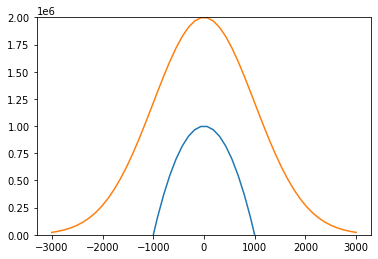

In [4]:
# Compare uniform disk with gaussian
v_max = 1000
v = np.linspace(-3000, 3000)
plt.plot(v, v_max**2 * (1-(v/v_max)**2))
plt.plot(v, 2*v_max**2 * np.exp(-v**2/2/v_max**2))
plt.ylim((0,2e6))

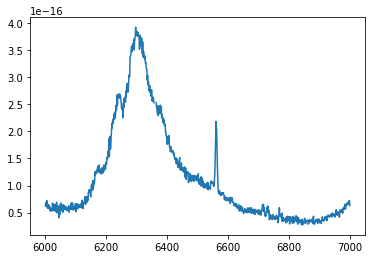

In [8]:
spec = SPECS['keck_early'][0]
idx = np.logical_and(spec['restwave'] > 6000, spec['restwave'] < 7000)
wave = spec['restwave'][idx]
plt.plot(wave, spec['flux'][idx])
v = np.linspace(-3000, 3000) # km/s
l = 6300*2.99e5/(v+2.99e5)


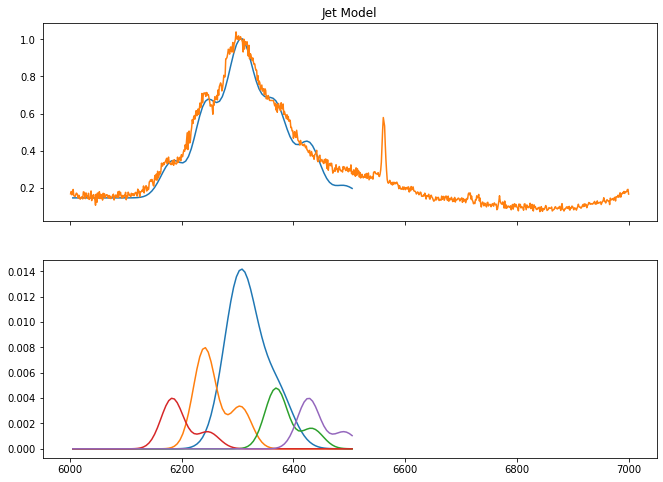

In [13]:
# jet model with components mirrored
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

wave = np.linspace(6000, 6500, 100)
lw1 = 29
lw2 = 20
lw3 = 20
flux = gaussian.gaussian(wave, 6300, 1, lw1) + gaussian.gaussian(wave, 6364, 1/3, lw1) +\
    gaussian.gaussian(wave, 6300-64, 0.4, lw2) + gaussian.gaussian(wave, 6300, 0.5/3, lw2) +\
    gaussian.gaussian(wave, 6300+64, 0.4*0.6, lw2) + gaussian.gaussian(wave, 6300+64+64, 0.4*0.6/3, lw2) +\
    gaussian.gaussian(wave, 6300-122, 0.2, lw3) + gaussian.gaussian(wave, 6300-122+64, 0.2/3, lw3) +\
    gaussian.gaussian(wave, 6300+122, 0.2, lw3) + gaussian.gaussian(wave, 6300+122+64, 0.2/3, lw3) +\
    0.003
#plt.axvline(6300-120)
ax1.plot(wave+5, flux/np.percentile(flux, 99))
ax2.plot(wave+5, gaussian.gaussian(wave, 6300, 1, lw1) + gaussian.gaussian(wave, 6364, 1/3, lw1))
ax2.plot(wave+5, gaussian.gaussian(wave, 6300-64, 0.4, lw2) + gaussian.gaussian(wave, 6300, 0.5/3, lw2))
ax2.plot(wave+5, gaussian.gaussian(wave, 6300+64, 0.4*0.6, lw2) + gaussian.gaussian(wave, 6300+64+64, 0.4*0.6/3, lw2))
ax2.plot(wave+5, gaussian.gaussian(wave, 6300-122, 0.2, lw3) + gaussian.gaussian(wave, 6300-122+64, 0.2/3, lw3))
ax2.plot(wave+5, gaussian.gaussian(wave, 6300+122, 0.2, lw3) + gaussian.gaussian(wave, 6300+122+64, 0.2/3, lw3))

spec = SPECS['keck_early'][0]
idx = np.logical_and(spec['restwave'] > 6000, spec['restwave'] < 7000)
idx = np.logical_and(idx, ~np.isnan(spec['flux']))
wave = spec['restwave'][idx]
ax1.plot(wave, spec['flux'][idx]/np.percentile(spec['flux'][idx], 99))
ax1.set_title('Jet Model')
fig.savefig('2022-07-20-oxygen-manual-profile-jet.png')

-62.58278145695385


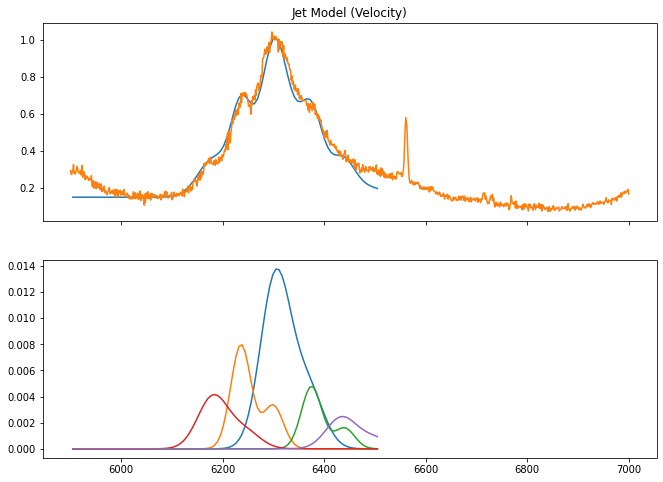

In [16]:
# jet model (velocity)
# now same but with velocites instead
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

def v2l(l0, v):
    return l0*2.99e5/(v+2.99e5)
print(v2l(6300, 3000)-6300)

wave = np.linspace(5900, 6500, 100)
lw1 = 30
lw2 = 20
lw3 = 30
v1 = 0
v2 = 3300
v3 = 6000
flux = gaussian.gaussian(wave, v2l(6300, v1), 1, lw1) + gaussian.gaussian(wave, v2l(6364, v1), 1/3, lw1) +\
    gaussian.gaussian(wave, v2l(6300, v2), 0.4, lw2) + gaussian.gaussian(wave, v2l(6364, v2), 0.5/3, lw2) +\
    gaussian.gaussian(wave, v2l(6300, -v2), 0.4*0.6, lw2) + gaussian.gaussian(wave, v2l(6364, -v2), 0.4*0.6/3, lw2) +\
    gaussian.gaussian(wave, v2l(6300, v3), 0.3, lw3) + gaussian.gaussian(wave, v2l(6364, v3), 0.3/3, lw3) +\
    gaussian.gaussian(wave, v2l(6300, -v3), 0.3*0.6, lw3) + gaussian.gaussian(wave, v2l(6364, -v3), 0.3*0.6/3, lw3) +\
    0.003
#plt.axvline(6300-120)
ax1.plot(wave+5, flux/np.percentile(flux, 99))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, v1), 1, lw1) + gaussian.gaussian(wave, v2l(6364, v1), 1/3, lw1))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, v2), 0.4, lw2) + gaussian.gaussian(wave, v2l(6364, v2), 0.5/3, lw2))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, -v2), 0.4*0.6, lw2) + gaussian.gaussian(wave, v2l(6364, -v2), 0.4*0.6/3, lw2))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, v3), 0.3, lw3) + gaussian.gaussian(wave, v2l(6364, v3), 0.3/3, lw3))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, -v3), 0.3*0.6, lw3) + gaussian.gaussian(wave, v2l(6364, -v3), 0.3*0.6/3, lw3))

spec = SPECS['keck_early'][0]
idx = np.logical_and(spec['restwave'] > 5900, spec['restwave'] < 7000)
idx = np.logical_and(idx, ~np.isnan(spec['flux']))
wave = spec['restwave'][idx]
ax1.plot(wave, spec['flux'][idx]/np.percentile(spec['flux'][idx], 99))
ax1.set_title('Jet Model (Velocity)')
fig.savefig('2022-07-20-oxygen-manual-profile-jet-velocity.png')

-62.58278145695385


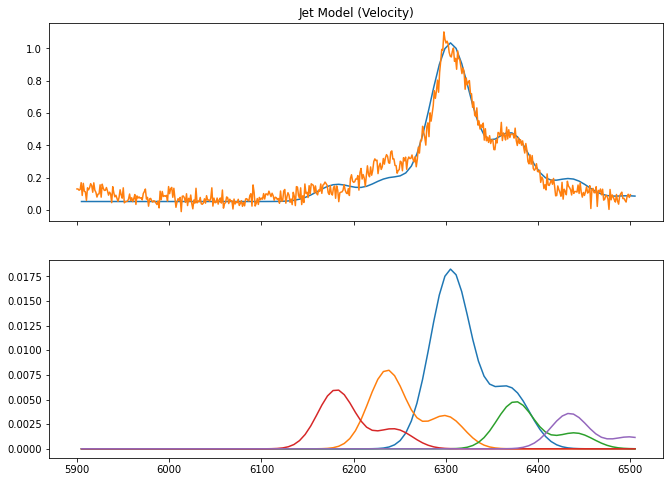

In [34]:
# jet model (velocity)
# now same but with velocites instead
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

def v2l(l0, v):
    return l0*2.99e5/(v+2.99e5)
print(v2l(6300, 3000)-6300)

wave = np.linspace(5900, 6500, 100)
lw1 = 22
lw2 = 20
lw3 = 20
v1 = 0
v2 = 3300
v3 = 6000
a1 = 1
a2 = 0.1
a3 = 0.1
flux = gaussian.gaussian(wave, v2l(6300, v1), a1, lw1) + gaussian.gaussian(wave, v2l(6364, v1), a1/3, lw1) +\
    gaussian.gaussian(wave, v2l(6300, v2), a2, lw2) + gaussian.gaussian(wave, v2l(6364, v2), a2/3, lw2) +\
    gaussian.gaussian(wave, v2l(6300, -v2), a2, lw2) + gaussian.gaussian(wave, v2l(6364, -v2), a2/3, lw2) +\
    gaussian.gaussian(wave, v2l(6300, v3), a3, lw3) + gaussian.gaussian(wave, v2l(6364, v3), a3/3, lw3) +\
    gaussian.gaussian(wave, v2l(6300, -v3), a3, lw3) + gaussian.gaussian(wave, v2l(6364, -v3), a3/3, lw3) +\
    0.001
#plt.axvline(6300-120)
ax1.plot(wave+5, flux/np.percentile(flux, 99))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, v1), 1, lw1) + gaussian.gaussian(wave, v2l(6364, v1), 1/3, lw1))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, v2), 0.4, lw2) + gaussian.gaussian(wave, v2l(6364, v2), 0.5/3, lw2))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, -v2), 0.4*0.6, lw2) + gaussian.gaussian(wave, v2l(6364, -v2), 0.4*0.6/3, lw2))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, v3), 0.3, lw3) + gaussian.gaussian(wave, v2l(6364, v3), 0.3/3, lw3))
ax2.plot(wave+5, gaussian.gaussian(wave, v2l(6300, -v3), 0.3*0.6, lw3) + gaussian.gaussian(wave, v2l(6364, -v3), 0.3*0.6/3, lw3))

spec = SPECS['keck_late'][0]
idx = np.logical_and(spec['restwave'] > 5900, spec['restwave'] < 6500)
idx = np.logical_and(idx, ~np.isnan(spec['flux']))
wave = spec['restwave'][idx]
ax1.plot(wave, spec['flux'][idx]/np.percentile(spec['flux'][idx], 99))
ax1.set_title('Jet Model (Velocity)')
fig.savefig('2022-07-20-oxygen-manual-profile-jet-velocity-kecklate.png')

-62.58278145695385


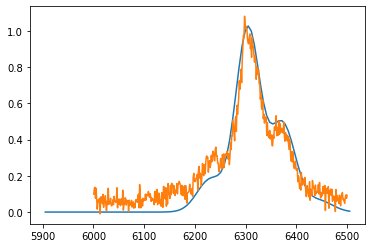

In [7]:
# now lets have a look at the late-time keck spectrum
# jet model (velocity)
# now same but with velocites instead
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

def v2l(l0, v):
    return l0*2.99e5/(v+2.99e5)
print(v2l(6300, 3000)-6300)

wave = np.linspace(5900, 6500, 100)
lw1 = 24
lw2 = 26
lw3 = 30
v1 = 0
v2 = 3600
v3 = 6000
flux = gaussian.gaussian(wave, v2l(6300, v1), 1, lw1) + gaussian.gaussian(wave, v2l(6364, v1), 1/3, lw1) +\
    gaussian.gaussian(wave, v2l(6300, v2), 0.2, lw2) + gaussian.gaussian(wave, v2l(6364, v2), 0.2/3, lw2) +\
    gaussian.gaussian(wave, v2l(6300, -v2), 0.2, lw2) + gaussian.gaussian(wave, v2l(6364, -v2), 0.2/3, lw2)

plt.plot(wave+5, flux/np.percentile(flux, 99))

spec = SPECS['keck_late'][0]
idx = np.logical_and(spec['restwave'] > 6000, spec['restwave'] < 6500)
idx = np.logical_and(idx, ~np.isnan(spec['flux']))
wave = spec['restwave'][idx]
ax1.plot(wave, spec['flux'][idx]/np.percentile(spec['flux'][idx], 99))

ax1.set_title('Jet Model (Velocity)')
#fig.savefig('2022-07-20-oxygen-manual-profile-jet-velocity-kecklate.png')

In [135]:
def line2velocity(wave0, wave):
    c = 2.99e5
    return wave0*c/wave-c
line2velocity(6300, 6230)

3359.550561797747

In [137]:
v2l(6300, 3000)

6237.417218543046

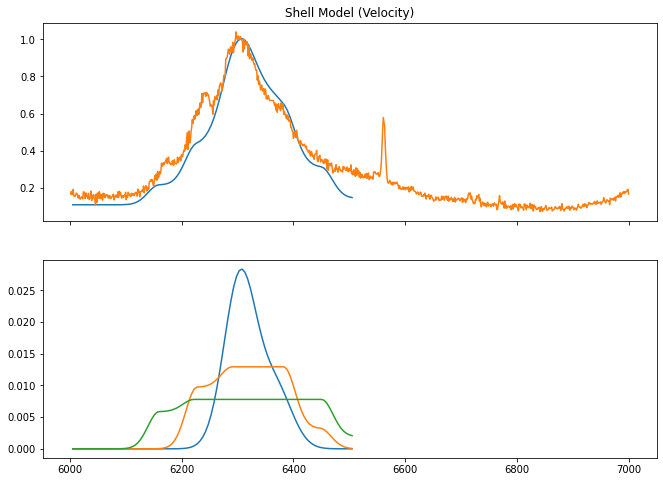

In [19]:
# shell model
# attempts with elongated gaussian for outer zones!
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

wave = np.linspace(6000, 6500, 100)
lw1 = 29
lw2 = 20
lw3 = 20

v2 = 3600
v3 = 6600

def v2l(l0, v):
    return l0*2.99e5/(v+2.99e5)

egauss = np.vectorize(gaussian.elongated_gaussian)

flux = gaussian.gaussian(wave, 6300, 2.0, lw1) + gaussian.gaussian(wave, 6364, 2.0/3, lw1) +\
    egauss(wave, 6300, 2.0, lw2, v2l(6300, -2*v2)-6300)+\
    egauss(wave, 6364, 2.0/3, lw2, v2l(6364, -2*v2)-6364)+\
    egauss(wave, 6300, 2.0, lw3, v2l(6300, -2*v3)-6300)+\
    egauss(wave, 6364, 2.0/3, lw3, v2l(6364, -2*v3)-6364)+\
    0.006
    #gaussian.gaussian(wave, 6300-64, 0.4, lw2) + gaussian.gaussian(wave, 6300, 0.5/3, lw2) +\
    #gaussian.gaussian(wave, 6300+64, 0.4*0.6, lw2) + gaussian.gaussian(wave, 6300+64+64, 0.4*0.6/3, lw2) +\
    #gaussian.gaussian(wave, 6300-122, 0.2, lw3) + gaussian.gaussian(wave, 6300-122+64, 0.2/3, lw3) +\
    #gaussian.gaussian(wave, 6300+122, 0.2, lw3) + gaussian.gaussian(wave, 6300+122+64, 0.2/3, lw3) +\
    #0.003
#plt.axvline(6300-120)
ax1.plot(wave+5, flux/np.percentile(flux, 99))
ax2.plot(wave+5, gaussian.gaussian(wave, 6300, 2.0, lw1) + gaussian.gaussian(wave, 6364, 2.0/3, lw1))
ax2.plot(wave+5, egauss(wave, 6300, 2.0, lw2, v2l(6300, -2*v2)-6300) + egauss(wave, 6364, 2.0/3, lw2, v2l(6364, -2*v2)-6364))
ax2.plot(wave+5, egauss(wave, 6300, 2.0, lw3, v2l(6300, -2*v3)-6300) + egauss(wave, 6364, 2.0/3, lw3, v2l(6364, -2*v3)-6364))
#ax2.plot(wave+5, )

spec = SPECS['keck_early'][0]
idx = np.logical_and(spec['restwave'] > 6000, spec['restwave'] < 7000)
idx = np.logical_and(idx, ~np.isnan(spec['flux']))
wave = spec['restwave'][idx]
ax1.plot(wave, spec['flux'][idx]/np.percentile(spec['flux'][idx], 99))
ax1.set_title('Shell Model (Velocity)')
fig.savefig('2022-07-20-oxygen-manual-profile-shell-velocity.png')

In [24]:
v2l(6300, -v3)-6300

129.01023890785018

In [28]:
f = egauss(wave, 6300, 1.0, lw3, v2l(6300, -v3)-6300)
np.trapz(f, wave)

0.9999999486594019

In [30]:
f = gaussian.gaussian(wave, 6300, 1.0, lw3)
np.trapz(f, wave)

1.000111786500622

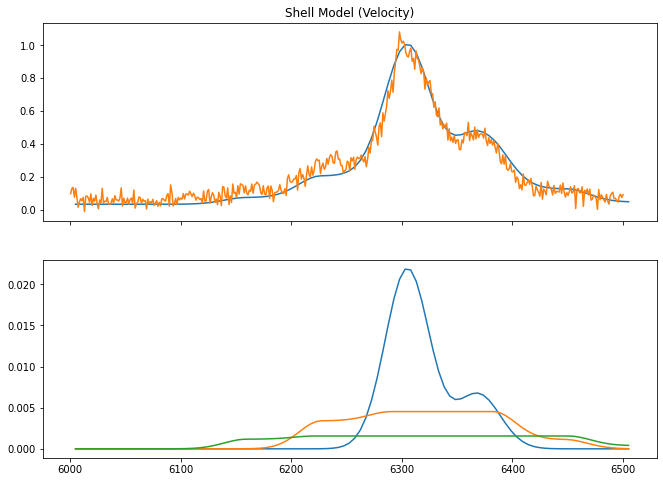

In [22]:
# attempts with elongated gaussian for outer zones!
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))
wave = np.linspace(6000, 6500, 100)
lw1 = 20
lw2 = 20
lw3 = 20

v2 = 3600
v3 = 6600

def v2l(l0, v):
    return l0*2.99e5/(v+2.99e5)

egauss = np.vectorize(gaussian.elongated_gaussian)

flux = gaussian.gaussian(wave, 6300, 1.1, lw1) + gaussian.gaussian(wave, 6364, 1/3, lw1) +\
    egauss(wave, 6300, 0.7, lw2, v2l(6300, -2*v2)-6300)+\
    egauss(wave, 6364, 0.7/3, lw2, v2l(6364, -2*v2)-6364)+\
    egauss(wave, 6300, 0.4, lw3, v2l(6300, -2*v3)-6300)+\
    egauss(wave, 6364, 0.4/3, lw3, v2l(6364, -2*v3)-6364)+\
    0.001
    #gaussian.gaussian(wave, 6300-64, 0.4, lw2) + gaussian.gaussian(wave, 6300, 0.5/3, lw2) +\
    #gaussian.gaussian(wave, 6300+64, 0.4*0.6, lw2) + gaussian.gaussian(wave, 6300+64+64, 0.4*0.6/3, lw2) +\
    #gaussian.gaussian(wave, 6300-122, 0.2, lw3) + gaussian.gaussian(wave, 6300-122+64, 0.2/3, lw3) +\
    #gaussian.gaussian(wave, 6300+122, 0.2, lw3) + gaussian.gaussian(wave, 6300+122+64, 0.2/3, lw3) +\
    #0.003
#plt.axvline(6300-120)
ax1.plot(wave+5, flux/np.percentile(flux, 99))
ax2.plot(wave+5, gaussian.gaussian(wave, 6300, 1.1, lw1) + gaussian.gaussian(wave, 6364, 1/3, lw1))
ax2.plot(wave+5, egauss(wave, 6300, 0.7, lw2, v2l(6300, -2*v2)-6300) + egauss(wave, 6364, 0.7/3, lw2, v2l(6364, -2*v2)-6364))
ax2.plot(wave+5, egauss(wave, 6300, 0.4, lw3, v2l(6300, -2*v3)-6300) + egauss(wave, 6364, 0.4/3, lw3, v2l(6364, -2*v3)-6364))


spec = SPECS['keck_late'][0]
idx = np.logical_and(spec['restwave'] > 6000, spec['restwave'] < 6500)
idx = np.logical_and(idx, ~np.isnan(spec['flux']))
wave = spec['restwave'][idx]
ax1.plot(wave, spec['flux'][idx]/np.percentile(spec['flux'][idx], 99))
ax1.set_title('Shell Model (Velocity)')
fig.savefig('2022-07-20-oxygen-manual-profile-shell-velocity-kecklate.png')